# Clustering

The task of finding underlying coherent groups in the data.

* hard clustering - assign each item to one cluster
* soft clustering - degree of belonging to a cluster
* hierarchical clustering - hierarchy of clusters, usually constructed bottom-to-top

<img src="figs/sklearn_cluster_comparison.png" width="80%">

<div style="text-align:center; font-size:80%">Illustration of clustering algorithms (figure from <a href="http://scikit-learn.org/stable/modules/clustering.html">scikit-learn documentation</a>)</div>

Depending on the clustering algorithm, we might need:
* a similarity metric on the items being clustered (function or matrix)
* a way to establish cluster centres
* a way to measure between cluster distance
* a way to measure cluster coherence

A notable difference between the algorithms is whether they can work with a matrix of pairwise similarities between arbitrary objects, or whether they need to be given a vector representation of the data items.

# Vector representations

This is necessarily a quick run through what is ultimately a large and complex topic. In a nutshell:

* There is a method called [word2vec](https://code.google.com/archive/p/word2vec/) (tutorial also [here](http://deeplearning4j.org/word2vec)). 
* This method is capable of producing for each word a high-dimensional vector (usually 50-200 dimensions is a decent choice).
* These vectors are such that words which are semantically related end up having similar vectors (cosine similarity is usually used)

Note: I will explain a lot more during the lecture, but reading up on the *word2vec* tutorial should give you roughly the same background information. A Finnish demo is [here](http://bionlp-www.utu.fi/wv_demo).

Examples of context words from the Finnish Internet corpus

<img src="figs/becher.png"/>
<img src="figs/koirakissa.png"/>



# K-means

The go-to clustering algorithm especially if your data is not badly violating its assumptions, and you have some idea about the number of clusters you'd like to obtain.

Material: http://scikit-learn.org/stable/modules/clustering.html#k-means

# Clustering words

Given that words are represented as vectors, it is simple to cluster them. To visualize the clustering, one can use 2D PCA to reduce the high-dimensional space into 2D (naturally with the associated loss of information!) Let's try:

* http://scikit-learn.org/
* http://matplotlib.org
* http://www.numpy.org/
* https://github.com/fginter/wvlib_light (to read word2vec models)

In [1]:
%matplotlib inline
from lib import lwvlib
import sklearn.decomposition
import sklearn.preprocessing
import matplotlib.pyplot as plt
import numpy as np


# Load in a matrix of 200-dimensional Finnish vectors, 70K most common words
fi_wv = lwvlib.load("pb34_wf_200_v2.100K.bin")
# Normalize
fi_wv.vectors = sklearn.preprocessing.normalize(fi_wv.vectors, norm='l2')

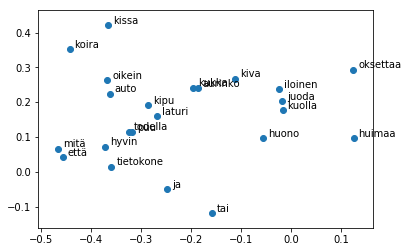

In [2]:
fi_words = [
    "koira", "kissa", "tietokone", "laturi", "kuolla", "juoda", "auto", "puu", "kukka", "kipu",
    "huono", "huimaa", "oksettaa", "kiva", "iloinen", "aurinko", "ja", "tai", "mitä", "että",
    "oikein", "todella","hyvin"
]

#Look up the row numbers for the words in the matrix
fi_word_indices = [fi_wv[w] for w in fi_words]

#2D projection of the data
pca2 = sklearn.decomposition.PCA(2)
fi_vectors_2d = pca2.fit_transform(fi_wv.vectors)

#Plot the vectors
plt.scatter(fi_vectors_2d[fi_word_indices,0], fi_vectors_2d[fi_word_indices,1])
for i, w in zip(fi_word_indices, fi_words):
    plt.annotate(s=w, xy=fi_vectors_2d[i], xytext=fi_vectors_2d[i]+(0.01,0.005))
    
### wv_fin, words_fin, word_indices_fin = wv, words, word_indices

Let's try that for English

In [3]:
en_wv = lwvlib.load("GoogleNews-vectors-negative300.100K.bin")
en_wv.vectors = sklearn.preprocessing.normalize(en_wv.vectors, norm='l2') #Normalize

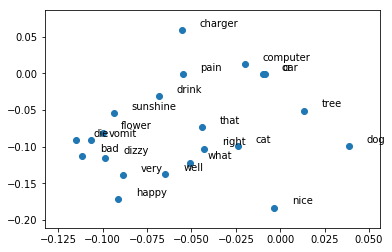

In [4]:
en_words= [
    "dog", "cat", "computer", "charger", "die", "drink", "car", "tree", "flower", "pain",
    "bad", "dizzy", "vomit", "nice", "happy", "sunshine", "or", "what", "that",
    "right", "very", "well"
]

#Look up the row numbers for the words in the matrix
en_word_indices = [en_wv[w] for w in en_words]

#2D projection of the data
pca2 = sklearn.decomposition.PCA(2)
en_vectors_2d = pca2.fit_transform(en_wv.vectors)

#Plot the vectors
plt.scatter(en_vectors_2d[en_word_indices,0], en_vectors_2d[en_word_indices,1])
for i, w in zip(en_word_indices, en_words):
    plt.annotate(s=w, xy=en_vectors_2d[i], xytext=en_vectors_2d[i]+(0.01,0.005))

# Clustering words

The vectors of the words can of course be clustered. All you need is a way to measure their similarity. Usually we'd use the cosine similarity but `sklearn` only gives us the Eucledian distance for K-means, so let's go with that, the results will be okay.

In [5]:
import sklearn.cluster

from pprint import pprint as pretty_print


k = sklearn.cluster.MiniBatchKMeans(batch_size=5000, n_clusters=10, random_state=1234)
distances = k.fit_transform(fi_wv.vectors)

print(distances.shape)

pretty_print(list(zip(fi_words, k.labels_[fi_word_indices]))) #Cluster label for each word

(100000, 10)
[('koira', 2),
 ('kissa', 2),
 ('tietokone', 5),
 ('laturi', 5),
 ('kuolla', 6),
 ('juoda', 6),
 ('auto', 5),
 ('puu', 5),
 ('kukka', 5),
 ('kipu', 2),
 ('huono', 9),
 ('huimaa', 9),
 ('oksettaa', 2),
 ('kiva', 9),
 ('iloinen', 9),
 ('aurinko', 2),
 ('ja', 0),
 ('tai', 0),
 ('mitä', 2),
 ('että', 2),
 ('oikein', 2),
 ('todella', 2),
 ('hyvin', 2)]


In [6]:
from collections import defaultdict
from pandas import DataFrame


def group_by_label(words, labels):
    grouped = defaultdict(list)
    for word, label in zip(words, labels):
            grouped[label].append(word)
    return grouped


def show_grouped(grouped):
    return DataFrame(list(sorted(grouped.items())), columns=['label', 'words']).style.hide_index()


grouped = group_by_label(fi_words, k.labels_[fi_word_indices])
show_grouped(grouped)

label,words
0,"['ja', 'tai']"
2,"['koira', 'kissa', 'kipu', 'oksettaa', 'aurinko', 'mitä', 'että', 'oikein', 'todella', 'hyvin']"
5,"['tietokone', 'laturi', 'auto', 'puu', 'kukka']"
6,"['kuolla', 'juoda']"
9,"['huono', 'huimaa', 'kiva', 'iloinen']"


## ...same for English

You can get vectors for English vocabulary for example here: https://code.google.com/archive/p/word2vec/ 

In [7]:
k = sklearn.cluster.MiniBatchKMeans(batch_size=5000, n_clusters=30, random_state=1234)
distances = k.fit_transform(en_wv.vectors)


grouped = group_by_label(en_words, k.labels_[en_word_indices])
show_grouped(grouped)

label,words
0,"['nice', 'happy', 'or', 'what', 'that', 'right', 'very', 'well']"
1,"['computer', 'charger', 'car']"
11,"['dog', 'cat', 'drink', 'flower', 'vomit']"
14,['pain']
15,"['die', 'dizzy']"
16,['bad']
29,"['tree', 'sunshine']"


The clusters above are built on 100K words, how about we try just with our example words?

In [8]:
k = sklearn.cluster.MiniBatchKMeans(batch_size=5000, n_clusters=7, random_state=1234)
distances = k.fit_transform(fi_wv.vectors[fi_word_indices])
    
grouped = group_by_label(fi_words, k.labels_)
show_grouped(grouped)

label,words
0,"['kuolla', 'juoda', 'oksettaa']"
1,['kipu']
2,"['huono', 'kiva', 'iloinen', 'mitä', 'että', 'oikein', 'todella', 'hyvin']"
3,['huimaa']
4,"['ja', 'tai']"
5,"['koira', 'kissa', 'tietokone', 'laturi', 'auto', 'puu', 'kukka']"
6,['aurinko']


In [9]:
k = sklearn.cluster.MiniBatchKMeans(batch_size=5000, n_clusters=7, random_state=1234)
distances=k.fit_transform(en_wv.vectors[en_word_indices])


grouped = group_by_label(en_words, k.labels_)
show_grouped(grouped)

label,words
0,"['what', 'that']"
1,['sunshine']
2,"['dog', 'cat']"
3,"['die', 'drink', 'flower', 'pain', 'dizzy', 'vomit']"
4,"['bad', 'nice', 'happy', 'right', 'very', 'well']"
5,"['computer', 'charger', 'car', 'tree']"
6,['or']


# Clustering documents

So we can cluster words. Sweet. How about whole documents? One way to cluster documents is to produce their vector representation, much like we had for the words, and then cluster them as before. So we need vectors for documents. There's many ways to do that, some fancy, some less so, but one simple option is to average the vectors of the words in the documents. Let's try.

Here's our all-time favorite Donald Trump tweets, each tagged, like this:

```
1       Why     _       WRB     _       _       _
2       the     _       DT      _       _       _
3       Supporters      _       NN      _       _       _
4       of      _       IN      _       _       _
5       Bernie  _       NNP     _       _       _
6       Sanders _       NNP     _       _       _
7       and     _       CC      _       _       _
8       Donald  _       NNP     _       _       _
9       Trump   _       NNP     _       _       _
10      are     _       VBP     _       _       _
11      Foretelling     _       VBG     _       _       _
12      the     _       DT      _       _       _
13      End     _       NN      _       _       _
14      of      _       IN      _       _       _
15      the     _       DT      _       _       _
16      35      _       CD      _       _       _
17      Year    _       NN      _       _       _
18      Bull    _       NNP     _       _       _
19      Market  _       NNP     _       _       _
20      in      _       IN      _       _       _
21      Bonds   _       NNP     _       _       _
22      https://t.co/2iDn4WqGU5 _       URL     _       _       _
```

In [10]:
def read_conll(f):
    sent=[]
    comment=[]
    for line in f:
        line=line.strip()
        if not line: # new sentence
            if sent:
                yield comment,sent
            comment=[]
            sent=[]
        elif line.startswith(u"#"):
            comment.append(line)
        else: #normal line
            sent.append(line.split(u"\t"))
    else:
        if sent:
            yield comment, sent

            
with open("trump2000.txt.conll", "r", encoding="utf-8") as f:
    tweets=list(sent for comment,sent in read_conll(f) if not sent[0][1].startswith(u"RT")) #ignore retweets

In [11]:
pretty_print(tweets[0])    #each tweet is one sentence
print()
print(" ".join(line[1] for line in tweets[0]))

[['1', 'Why', '_', 'WRB', '_', '_', '_'],
 ['2', 'the', '_', 'DT', '_', '_', '_'],
 ['3', 'Supporters', '_', 'NN', '_', '_', '_'],
 ['4', 'of', '_', 'IN', '_', '_', '_'],
 ['5', 'Bernie', '_', 'NNP', '_', '_', '_'],
 ['6', 'Sanders', '_', 'NNP', '_', '_', '_'],
 ['7', 'and', '_', 'CC', '_', '_', '_'],
 ['8', 'Donald', '_', 'NNP', '_', '_', '_'],
 ['9', 'Trump', '_', 'NNP', '_', '_', '_'],
 ['10', 'are', '_', 'VBP', '_', '_', '_'],
 ['11', 'Foretelling', '_', 'VBG', '_', '_', '_'],
 ['12', 'the', '_', 'DT', '_', '_', '_'],
 ['13', 'End', '_', 'NN', '_', '_', '_'],
 ['14', 'of', '_', 'IN', '_', '_', '_'],
 ['15', 'the', '_', 'DT', '_', '_', '_'],
 ['16', '35', '_', 'CD', '_', '_', '_'],
 ['17', 'Year', '_', 'NN', '_', '_', '_'],
 ['18', 'Bull', '_', 'NNP', '_', '_', '_'],
 ['19', 'Market', '_', 'NNP', '_', '_', '_'],
 ['20', 'in', '_', 'IN', '_', '_', '_'],
 ['21', 'Bonds', '_', 'NNP', '_', '_', '_'],
 ['22', 'https://t.co/2iDn4WqGU5', '_', 'URL', '_', '_', '_']]

Why the Supporters of B

Let us sum up the vectors of all relevant words in each tweet



In [12]:
import re
import sklearn.preprocessing

ofinterest=re.compile(u".*")#re.compile(u"^JJ")#re.compile(u"^(JJ|N.*|VB.*|RB)$")
tweet_vectors=np.zeros((len(tweets), en_wv.vectors.shape[1])) #matrix of zeroes, 2000x300

print(tweet_vectors.shape)    # So we have 2000 tweets and 300-dimensional vectors, fair enough

for i, tweet in enumerate(tweets):
    counter=0
    for line in tweet:
        if not ofinterest.match(line[3]):
            continue
        word = line[1]    # the usual conll parsing thing
        row_idx = en_wv.get(word.lower())    # look-up the lowercase version
        if row_idx is not None:    # many of these words are not in the vector model, then we get a None
            tweet_vectors[i] += en_wv.vectors[row_idx]
            counter += 1 # how many of these we get
    if counter > 0:
        tweet_vectors[i] /= counter # average


tweet_vectors_norm=sklearn.preprocessing.normalize(tweet_vectors, norm='l2')

print(tweet_vectors_norm)

(956, 300)
[[ 0.05092371  0.07404875  0.04266263 ...  0.01324429  0.04335121
  -0.03092889]
 [ 0.01502189  0.04557208 -0.05028165 ... -0.05578275  0.01211541
  -0.02073304]
 [ 0.03011552  0.06716104 -0.02680386 ... -0.10697135 -0.00298905
  -0.04263458]
 ...
 [ 0.03000128  0.05053919  0.0659948  ... -0.07759767  0.02343684
  -0.0610384 ]
 [ 0.00995172  0.04334191  0.02136508 ... -0.04149039  0.09717508
  -0.02065629]
 [ 0.07954239 -0.01065946  0.03772105 ... -0.03163816  0.00785336
  -0.05514153]]


In [13]:
#And now we can cluster as before

k = sklearn.cluster.MiniBatchKMeans(n_clusters=10, batch_size=800)
distances=k.fit_transform(tweet_vectors_norm)

#the nearest tweets for every cluster, in no particular order
nearest = np.argpartition(distances, 10, axis=0)[:10]

tweet_texts = [" ".join(l[1] for l in tweet) for tweet in tweets]

for cluster_num, cluster in enumerate(nearest.T):
    print("**************", cluster_num,"***********")
    for tweet_id in cluster:
        print(">> ",tweet_id,">> ",tweet_texts[tweet_id])
    print()

************** 0 ***********
>>  464 >>  So the female journalist who Trump 's campaign manager assaulted -- it looks like she 's a huge Trump fan . Trump 's America .
>>  595 >>  @NikoTheFarmer Typical Trump supporter , when presented with facts , they blatantly deny it . You 're even more messed up than I thought
>>  548 >>  @morningmika Heard Trump 's hacked voicemail from you and Joe No wonder your show has bolstered Trump during his entire campaign Shame on you
>>  305 >>  Never Trump ! The `` Village Idiots '' are both having an `` orgasm '' over Trumps win ! Hey Joe , you to have `` little hands '' https://t.co/YS3bfHWgAD
>>  922 >>  This also explains who Trump voters are ➖ Hey , Republicans , stop hating on Trump voters | Fox News | https://t.co/10PS5lAn1F
>>  180 >>  Trump will bring back ' Americans lost glory of God in the American state . why ? becouse he Trump is not card ward .
>>  582 >>  And fuck me , I hate Trump too , but cut the shit , holding your hand up to take s